# Posterior Distributions
## Nathan Dilla & John Ian Haviland
### April 7, 2024

Nathan's video: https://www.loom.com/share/86f82f41f9d6427f9d78468b151445f6

John's Video: https://www.loom.com/share/3f46d160869a423d9a2d08e0b753e366?sid=fb8e6bb6-4032-4c76-a722-83d556968246

#### Background

Universities are vibrant ecosystems with diverse spaces catering to the academic, social, and recreational needs of students. The flow of student traffic across these spaces provides valuable insights into campus life dynamics, influencing everything from facility management to event planning and safety protocols. This activity focuses on a critical aspect of campus analytics: understanding how students interact with different campus locations and what these interactions reveal about their preferences and behaviors.

We have simulated data on student movements between five pivotal locations on campus: the Student Union, Arena, Thunderground, Lopes Way, and the Dorms. Each of these sites plays a unique role in campus life, from serving as social hubs to hosting special events and offering leisure activities. By examining the flow of students between these areas, we aim to uncover patterns that can inform better campus resource allocation, enhance student experiences, and ensure that facilities meet the community's evolving needs.

We will apply Markov Chain Monte Carlo (MCMC) methods to estimate the posterior distributions of student preferences for each campus location. By analyzing these distributions, we can gain deeper insights into the probability of students favoring certain locations over others, given the observed movements. This approach offers a powerful framework for decision-making, enabling the university to tailor its services and facilities to better match student needs and preferences.

#### Import Libraries

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import networkx as nx

#### Initial Table Creation

In [18]:
activity_matrix = np.array([
    [1, 3, 5, 3, 3],  # Student Union
    [7, 1, 4, 6, 3],  # Arena
    [8, 2, 2, 5, 4],  # Thunderground
    [5, 4, 5, 3, 1],  # Lopes Way
    [2, 4, 1, 5, 1]   # Dorms
])

states = ['Student Union', 'Arena', 'Thunderground', 'Lopes Way', 'Dorms']

activity_df = pd.DataFrame(activity_matrix, index=states, columns=states)

# Add the total visits per current location
activity_df['Total'] = activity_df.sum(axis=1)

# Display df
activity_df


,Student Union,Arena,Thunderground,Lopes Way,Dorms,Total
Student Union,1,3,5,3,3,15
Arena,7,1,4,6,3,21
Thunderground,8,2,2,5,4,21
Lopes Way,5,4,5,3,1,18
Dorms,2,4,1,5,1,13


#### Calculating Conditional Probabilities & Transition Matrix

In [19]:
# Calculate conditional probabilities
conditional_prob_df = activity_df.div(activity_df['Total'], axis=0)

# Drop 'Total' column
conditional_prob_df = conditional_prob_df.drop('Total', axis=1)

# Adjust table's conditional probabilities to sum up to 1
conditional_prob_df['Total'] = conditional_prob_df.sum(axis=1)

# Convert the conditional probabilities df into a transition matrix
transition_matrix = conditional_prob_df.drop('Total', axis=1).values

# Display conditional probability table and transition matrix
conditional_prob_df, transition_matrix

(               Student Union     Arena  Thunderground  Lopes Way     Dorms  \
 Student Union       0.066667  0.200000       0.333333   0.200000  0.200000   
 Arena               0.333333  0.047619       0.190476   0.285714  0.142857   
 Thunderground       0.380952  0.095238       0.095238   0.238095  0.190476   
 Lopes Way           0.277778  0.222222       0.277778   0.166667  0.055556   
 Dorms               0.153846  0.307692       0.076923   0.384615  0.076923   
 
                Total  
 Student Union    1.0  
 Arena            1.0  
 Thunderground    1.0  
 Lopes Way        1.0  
 Dorms            1.0  ,
 array([[0.06666667, 0.2       , 0.33333333, 0.2       , 0.2       ],
        [0.33333333, 0.04761905, 0.19047619, 0.28571429, 0.14285714],
        [0.38095238, 0.0952381 , 0.0952381 , 0.23809524, 0.19047619],
        [0.27777778, 0.22222222, 0.27777778, 0.16666667, 0.05555556],
        [0.15384615, 0.30769231, 0.07692308, 0.38461538, 0.07692308]]))

#### Plotting Markov Chain

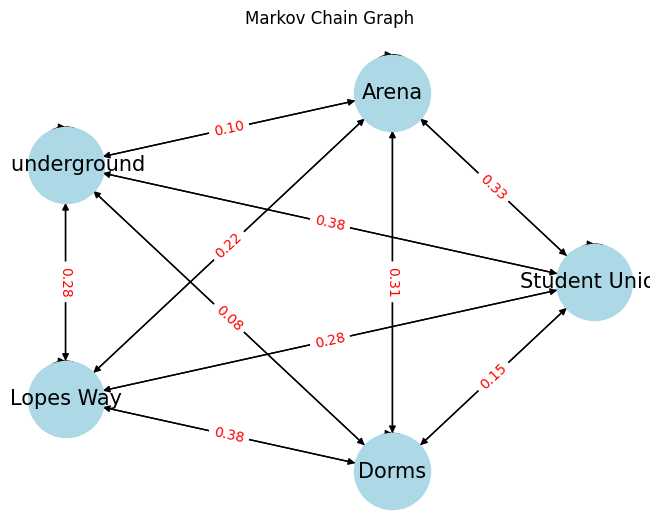

In [20]:
# Function to plot Markov chain
def plot_markov_chain(trans_mat, states):

    # Graph from transition matrix
    G = nx.DiGraph()

    # Add nodes
    for state in states:
        G.add_node(state)

    # Add edges w/ probabilities as labels
    for i, origin_state in enumerate(states):
        for j, destination_state in enumerate(states):
            prob = trans_mat[i, j]
            if prob > 0:
                G.add_edge(origin_state, destination_state, weight=prob, label="{:.02f}".format(prob))

    # Draw graph w/ circular layout
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=15)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title('Markov Chain Graph')
    plt.show()

# Plot MC graph
plot_markov_chain(transition_matrix, states)

#### Calculating Steady-State Probabilities & Transition Probability

In [21]:
# Function that calculates steady-state probabilities
def calculate_steady_state(trans_mat, threshold=1e-6, max_iter=1000):
    num_states = trans_mat.shape[0]
    
    # Uniform distribution to start
    prob_vector = np.full(num_states, 1 / num_states)
    iterations = 0

    # Perform power method iterations until convergence or max iterations reached
    for iterations in range(max_iter):
        new_prob_vector = prob_vector.dot(trans_mat)
        
        # If converged, break
        if np.allclose(new_prob_vector, prob_vector, atol=threshold):
            break
        prob_vector = new_prob_vector

    return new_prob_vector, iterations

# Calculate steady-state probabilities
steady_state_probs, iterations = calculate_steady_state(transition_matrix)

# Probability of going to the Union, then going to Lopes Way, then going to the Dorms
# P(Student Union -> Lopes Way -> Dorms) = P(Student Union -> Lopes Way) * P(Lopes Way -> Dorms)   
prob_union_lopesway_dorms = transition_matrix[states.index('Student Union'), states.index('Lopes Way')] * \
                               transition_matrix[states.index('Lopes Way'), states.index('Dorms')]
                               
print(f"Number of iterations to reach steady state: {iterations}")

print(f"P(Student Union -> Lopes Way -> Dorms) = {prob_union_lopesway_dorms:.4f}")

Number of iterations to reach steady state: 9
P(Student Union -> Lopes Way -> Dorms) = 0.0111


#### Calculating Fifth Step Probabilities

In [22]:
# Uniform distribution to start
spv = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Calculate fifth step probabilities
fifth_step_prob = spv.dot(np.linalg.matrix_power(transition_matrix, 5))

fifth_step_prob

array([0.24126087, 0.17179216, 0.21026554, 0.24000184, 0.13667958])

#### Formulating a Question: 

##### "What is the probabilistic distribution of student engagement or presence across various campus locations over time, given certain initial assumptions or observed data, and how do these distributions vary with changes in specific location attributes or external conditions?

#### Simulating Markov Chain Monte Carlo (MCMC)

In [24]:
num_iterations = 10000

# Initial alpha and beta parameters (arbitrary)
alpha = np.zeros(5)
beta = np.ones(5)

# Alpha and beta chains to store the simulation results
alpha_chain = np.zeros((num_iterations, 5))
beta_chain = np.zeros((num_iterations, 5))

# Probabilities for each state
state_prob_chain = np.zeros((num_iterations, 5))

# Function that defines softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Function that defines acceptance function w/ squared error
def acceptance_function(observed_probs, proposed_probs):
   
    return np.exp(-np.sum((observed_probs - proposed_probs)**2))

# Observed probabilities
observed_probs = steady_state_probs

# Run Metropolis-Hastings algorithm
for i in range(num_iterations):
    
    # Propose new values for alpha and beta from a normal distribution
    proposed_alpha = alpha + np.random.normal(0, 0.1, 5)
    proposed_beta = beta + np.random.normal(0, 0.1, 5)
    
    # Calculate new proposed probabilities using softmax function
    proposed_probs = softmax(proposed_alpha)
    
    # Calculate acceptance probability
    acceptance_prob = acceptance_function(observed_probs, proposed_probs)
    
    # Accept or reject the proposed values
    if acceptance_prob > np.random.rand():
        alpha = proposed_alpha
        beta = proposed_beta
    
    # Store results of each iteration
    alpha_chain[i] = alpha
    beta_chain[i] = beta
    state_prob_chain[i] = proposed_probs

# Calculate average alpha and beta values over the chain
avg_alpha = np.mean(alpha_chain, axis=0)
avg_beta = np.mean(beta_chain, axis=0)
avg_state_probs = np.mean(state_prob_chain, axis=0)

# Print MCMC simulation values
print(f"The average alpha values are:\n"
      f"Student Union: {avg_alpha[0]:.4f}\n"
      f"Arena: {avg_alpha[1]:.4f}\n"
      f"Thunderground: {avg_alpha[2]:.4f}\n"
      f"Lopes Way: {avg_alpha[3]:.4f}\n"
      f"Dorms: {avg_alpha[4]:.4f}\n")

print(f"The average beta values are:\n"
      f"Student Union: {avg_beta[0]:.4f}\n"
      f"Arena: {avg_beta[1]:.4f}\n"
      f"Thunderground: {avg_beta[2]:.4f}\n"
      f"Lopes Way: {avg_beta[3]:.4f}\n"
      f"Dorms: {avg_beta[4]:.4f}\n")

print(f"The average state probabilities are:\n"
      f"Student Union: {avg_state_probs[0]:.4f}\n"
      f"Arena: {avg_state_probs[1]:.4f}\n"
      f"Thunderground: {avg_state_probs[2]:.4f}\n"
      f"Lopes Way: {avg_state_probs[3]:.4f}\n"
      f"Dorms: {avg_state_probs[4]:.4f}")


The average alpha values are:
Student Union: -0.4019
Arena: -2.4008
Thunderground: -4.7265
Lopes Way: 0.3096
Dorms: 5.6077

The average beta values are:
Student Union: 3.1478
Arena: -5.0239
Thunderground: 1.9709
Lopes Way: 2.4342
Dorms: 9.8235

The average state probabilities are:
Student Union: 0.0200
Arena: 0.0033
Thunderground: 0.0324
Lopes Way: 0.0293
Dorms: 0.9150


#### Interpreting the results:

Alpha Values: Represent the inherent attractiveness or aversiveness of each location. Negative values (Student Union, Arena, Thunderground) suggest factors that might deter students, whereas positive values (Lopes Way, Dorms) indicate attractions.

Beta Values: These were intended to modify the effect of the alpha values. The simulation process doesn't explicitly use them in calculating the state probabilities and were adjusted alongside alpha values without a clear role in this specific implementation. 

State Probabilities: Show the likelihood of students being in each location. The Dorms have the highest probability (91.5%), indicating that, based on the model and observed data, students are most likely to be found there. The other locations have significantly lower probabilities, with the Arena being the least likely (0.33%).